In [1]:
# Purpose: Quickly analysing ENSOWind EXP to see if all okay
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Now working with seal data from Adele (see her email from 04/08/2022, 10:28 AEST)

In [2]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ryf = '01deg_jra55v13_ryf9091'
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-120, -50)
lat_slice  = slice(-75.5,-60)

In [3]:
# topography data for plotting:
ht = cc.querying.getvar(ryf,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(ryf,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

open saved seal data

In [4]:
%%time
base_seal = '/g/data/v45/akm157/data/meop_seal_data/Australia/DATA_ncARGO_interp/'
outpath = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091/seal_data_comparison/WAP_MEOP_profiles_interpolated.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
meop_temp = profile_data.meop_temp
date = profile_data.date

CPU times: user 361 ms, sys: 217 ms, total: 578 ms
Wall time: 745 ms


In [5]:
meop_temp[0]

<xarray.DataArray 'meop_temp' ()>
array(-0.491187)
Coordinates:
    profile_number  int64 0

Text(0.5, 1.0, '200 m temperature from seal profiles')

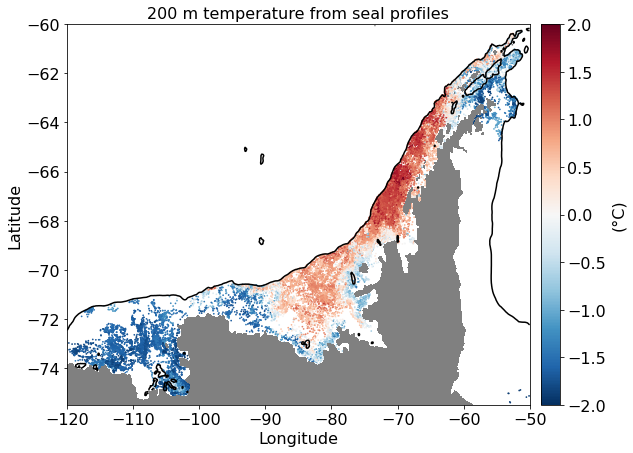

In [6]:
# plot unbinned data:
fontsize = 16
depth_slice = 1000

plt.figure(figsize=(10,7))
sc = plt.scatter(lon_obs,lat_obs,c=meop_temp,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.xlim(-120,-50)
plt.ylim(-75.5,-60)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title(str(200)+' m temperature from seal profiles', fontsize=fontsize)

## Bin seal data into lat/lon bins:
Redo this step, but first delete any obs profiles where model profiles are nan.

In [7]:
### load data for this year:
start_time='2150-01-01'
end_time='2159-12-31'

temp_ryf = cc.querying.getvar(ryf,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_ryf = temp_ryf.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')                          
temp_ryf = temp_ryf.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_ryf = temp_ryf.load()

In [8]:
# for comparing seal data to IAF:
cycle2 = '01deg_jra55v140_iaf_cycle2'
cycle3 = '01deg_jra55v140_iaf_cycle3'

start_time='2005-02-01'
end_time='2015-10-31'

temp_cycle2 = cc.querying.getvar(cycle2,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle2 = temp_cycle2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle2 = temp_cycle2.load()

temp_cycle3 = cc.querying.getvar(cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle3 = temp_cycle3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
temp_cycle3 = temp_cycle3.load()

### same for the ACCESS-OM2-1 model

In [9]:
# for comparing seal data to IAF:
cycle5 = '1deg_jra55_iaf_omip2_cycle5'
cycle6 = '1deg_jra55_iaf_omip2_cycle6'

start_time='2005-02-01'
end_time='2015-10-31'

temp_cycle5 = cc.querying.getvar(cycle5,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle5 = temp_cycle5.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

temp_cycle6 = cc.querying.getvar(cycle6,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_cycle6 = temp_cycle6.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest').load()

In [10]:
xt_ocean = temp_ryf.xt_ocean
yt_ocean = temp_ryf.yt_ocean
st_ocean = temp_ryf.st_ocean

## Select out model data from same months and locations as seal profiles:
Repeat this to find closest _non-land_ model grid point.

In [11]:
%%time
nprofiles = len(date)
model_temp_profiles = np.zeros((nprofiles))
model_lat_profiles = np.zeros(nprofiles)
model_lon_profiles = np.zeros(nprofiles)

# find corresponding model profiles:
for profile in range(nprofiles):
    # skip iteration if file already exists
    if os.path.isfile('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-1_cycle6.nc') == True:
        print('---------------------------------------------------------')
        print('WAP_model_profiles.nc already exists, skipping iterations')
        print('---------------------------------------------------------')
    break
   
    if profile%1000 == 0:
        print('profile '+str(profile)+'/'+str(nprofiles))
    profile_month = date[profile].dt.month.values
    
    # for RYF:
    #model_temp_profiles[profile] = temp_ryf.sel(month=profile_month).sel(xt_ocean=lon_obs[profile],method='nearest')\
    #    .sel(yt_ocean=lat_obs[profile],method='nearest')
    
    ## for IAF:
    profile_year = date[profile].dt.year.values
    start_date = str(profile_year)+'-'+str(profile_month)
    end_date = str(profile_year)+'-'+str(profile_month)
    model_temp_profiles[profile] = temp_cycle6.sel(time=slice(start_date,end_date)).sel(xt_ocean=lon_obs[profile],method='nearest')\
        .sel(yt_ocean=lat_obs[profile],method='nearest')
    ## end for IAF
    
    

    # check if it has selected a land point:
    '''if np.isnan(model_temp_profiles[profile]):
        # IAF
        temp_slice = temp_cycle2.sel(time=slice(start_date,end_date)).squeeze()
        # RYF
        #temp_slice = temp_ryf.sel(month=profile_month).squeeze()
        # fill in nans once back in y direction, once back in x direction then forwards once in both directions:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        # repeat:
        temp_slice = temp_slice.bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)\
            .bfill(dim='yt_ocean',limit=1).bfill(dim='xt_ocean',limit=1)\
            .ffill(dim='yt_ocean',limit=1).ffill(dim='xt_ocean',limit=1)
        model_temp_profiles[profile] = temp_slice.sel(xt_ocean=lon_obs[profile],method='nearest')\
            .sel(yt_ocean=lat_obs[profile],method='nearest')
        # This expands everything in  at least 2 grid points (i.e. ~ 10 km). 
        # If there is no matching grid point after that, we will nan the model profile later to match.'''
    
    model_lon_profiles[profile] = xt_ocean.sel(xt_ocean=lon_obs[profile],method='nearest')
    model_lat_profiles[profile] = yt_ocean.sel(yt_ocean=lat_obs[profile],method='nearest')

# save data:
model_temp_profiles = xr.DataArray(model_temp_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'model profiles')
model_lon_profiles = xr.DataArray(model_lon_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of model profiles')
model_lat_profiles = xr.DataArray(model_lat_profiles, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of model profiles')

# save data set if it not already exists
if os.path.isfile('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-1_cycle6.nc') == False:
    ds = xr.Dataset({'model_temp_profiles': model_temp_profiles,'model_lon_profiles':model_lon_profiles,'model_lat_profiles':model_lat_profiles})
    ds.to_netcdf('/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-1_cycle6.nc') # save into my own folder

---------------------------------------------------------
WAP_model_profiles.nc already exists, skipping iterations
---------------------------------------------------------
CPU times: user 2.26 ms, sys: 1.22 ms, total: 3.48 ms
Wall time: 3.99 ms


In [12]:
# open saved model profiles:
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
# outpath = '/g/data/v45/akm157/model_data/access-om2/'+ryf+'/seal_data_comparison/WAP_model_profiles.nc'
# profile_data = xr.open_dataset(outpath)
# lat_model = profile_data.model_lat_profiles
# lon_model = profile_data.model_lon_profiles
# ryf_temp = profile_data.model_temp_profiles
# ryf_temp = ryf_temp.load()

# outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles.nc'
outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-01_cycle3.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle3+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle3_temp = profile_data.model_temp_profiles
cycle3_temp = cycle3_temp.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-01_cycle2.nc'
#outpath = '/g/data/v45/akm157/model_data/access-om2/'+cycle2+'/seal_data_comparison/WAP_model_profiles_avoid_land.nc'
profile_data = xr.open_dataset(outpath)
lat_model = profile_data.model_lat_profiles
lon_model = profile_data.model_lon_profiles
cycle2_temp = profile_data.model_temp_profiles
cycle2_temp = cycle2_temp.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-1_cycle5.nc'
profile_data = xr.open_dataset(outpath)
lat_model_1deg = profile_data.model_lat_profiles
lon_model_1deg = profile_data.model_lon_profiles
cycle5_temp = profile_data.model_temp_profiles.load()

outpath = '/g/data/e14/mv7494/seal_data_comparison/WAP_model_profiles_ACCESS-OM2-1_cycle6.nc'
profile_data = xr.open_dataset(outpath)
lat_model_1deg = profile_data.model_lat_profiles
lon_model_1deg = profile_data.model_lon_profiles
cycle6_temp = profile_data.model_temp_profiles.load()


# need to assign lat/lon coords for binning:
#iaf_temp = iaf_temp.assign_coords({'lon':lon_model,'lat':lat_model})

In [13]:
cycle6_temp

<xarray.DataArray 'model_temp_profiles' (profile_number: 42213)>
array([0.7868042 , 0.54812622, 0.54812622, ..., 0.69500732, 0.57095337,
       0.57095337])
Coordinates:
  * profile_number  (profile_number) int64 0 1 2 3 4 ... 42209 42210 42211 42212

CPU times: user 4.91 s, sys: 1.32 s, total: 6.23 s
Wall time: 4.77 s


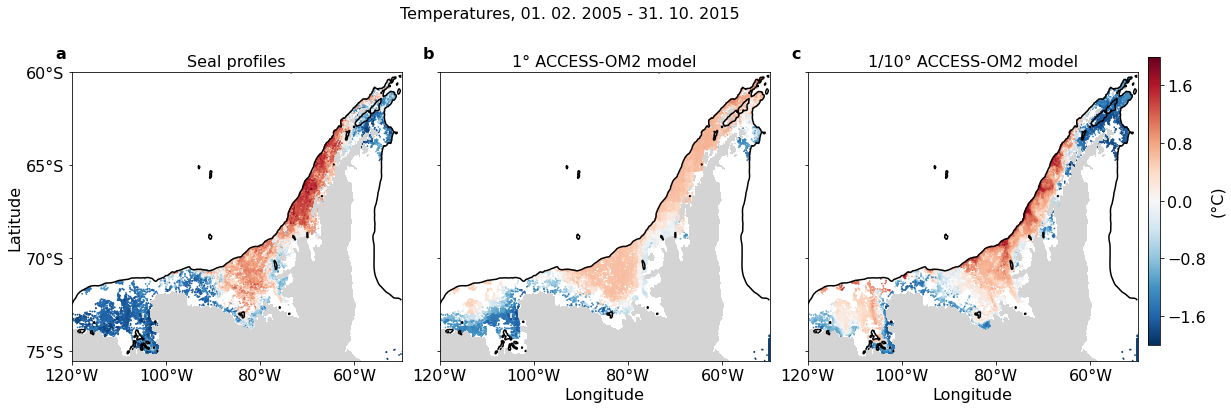

In [14]:
%%time
fontsize = 16
depth_slice = 200

# Take mean of cycle2 and cycle3:
iaf_temp = (cycle3_temp+cycle2_temp)/2
iaf_temp_1deg = (cycle5_temp+cycle6_temp)/2

fig = plt.figure(figsize=(16,10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3) 
       
# first panel with seal OBS data
# -------------------------------------------------------------------------------------------------- #
for f in [0,1,2]:
    if f == 0:
        panel = gs[0,0]; lon = lon_obs; lat = lat_obs; data = meop_temp; scale = 1; title_str = 'Seal profiles'
    if f == 1:
        panel = gs[0,1]; lon = lon_model; lat = lat_model; data = (iaf_temp_1deg); scale = 1; title_str = '1° ACCESS-OM2 model'        
    if f == 2:
        panel = gs[0,2]; lon = lon_model; lat = lat_model; data = (iaf_temp); scale = 1; title_str = '1/10° ACCESS-OM2 model'         
#     if f == 4:
#         panel = gs[1,1]; lon = lon_model; lat = lat_model; data = iaf_temp_1deg-meop_temp; scale = 1; title_str = 'ACCESS-OM2-1 \n difference to seal profiles'        
#     if f == 5:
#         panel = gs[1,2]; lon = lon_model; lat = lat_model; data = iaf_temp-meop_temp; scale = 1; title_str = 'ACCESS-OM2-01 \n difference to seal profiles'     
        
        
    ax1 = plt.subplot(panel)    

    ascii_nrs = [0,1,2,0,3,4]
    ax1.text(-.05, 1.05, string.ascii_lowercase[ascii_nrs[f]], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    sc = plt.scatter(lon,lat,c=data,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
    cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k', linewidth=1.25)
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='#d4d4d4') # light grey land
    plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0],linewidth='4',colors='black') # light grey land

    

    plt.xlim(-120,-50); plt.ylim(-75.5,-60)
    plt.tick_params(labelsize=fontsize)
    # replace lables with °W/°S labels
    labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['120°W', '100°W', '80°W', '60°W']) # replace labels in °N with across-shelf distance
    plt.locator_params(axis='y', nbins=4) # only 4 y-axis ticks
    labels = [item.get_text() for item in ax1.get_yticklabels()]; ax1.set_yticklabels(['', '75°S', '70°S', '65°S', '60°S'])

    if f in [4,5]:
        # adding the region rectangles for AS and BS
        AS = [-127,-101,-77,-70]; BS = [-101,-80,-77,-70]; PR = [-80,-63, -74, -63]
        # # drawing the AS and BS rectangles
        for r in range(4): # loop through the four sides of the rectangle
            if r == 0: lons = [AS[0],AS[1]]; lats = [AS[2], AS[2]] # bottom
            if r == 1: lons = [AS[0],AS[1]]; lats = [AS[3], AS[3]] # top
            if r == 2: lons = [AS[0],AS[0]]; lats = [AS[2], AS[3]] # left
            if r == 3: lons = [AS[1],AS[1]]; lats = [AS[2], AS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        for r in range(3): # loop through the four sides of the rectangle
            if r == 0: lons = [BS[0],BS[1]]; lats = [BS[2], BS[2]] # bottom
            if r == 1: lons = [BS[0],BS[1]]; lats = [BS[3], BS[3]] # top
            if r == 2: lons = [BS[1],BS[1]]; lats = [BS[2], BS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        # adding text label
        ax1.text( -119, -75, 'AS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -75, 'BS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    plt.title(title_str, fontsize=fontsize) # add title

    if f in [0]: plt.ylabel('Latitude',fontsize=fontsize); plt.xlabel(None)
    if f in [1,2,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None) 
    # if f in [1,2]:   ax1.set_xticklabels([]); ax1.set(xlabel=None) # remove superfluous labels
    plt.xlabel('Longitude', fontsize=fontsize)

    if f in [0]: 
        plt.xlabel(None)            
        # add colour bar 
        # cax = fig.add_axes([.07, .4, .25, .02]) # for horizontal colour bar
        #                 ([x0, y0, width, height])
        cax = fig.add_axes([1, .51,   .01,     .4]) # for vertical colour bar

        cb = plt.colorbar(sc, cax = cax, shrink=1, orientation='vertical'); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        # cb.add_lines(p11) # add contours to colour bar
        
    if f in [4,5]:
        # Calculate the bias that goes into the AS and BS regions
        diff = data # difference between OBS and model
        
        # mask out all Amundsen Sea profiles, fill rest with nan and  replace all non-nan values with the 1 index
        AS_profiles = (lon_obs.where((lon_obs > -120) & (lon_obs < -101))).fillna(np.nan); AS_profiles = AS_profiles.where(np.logical_or(AS_profiles.isnull(), xr==0), 1)
        bias_AS = str(np.round((diff*AS_profiles).mean().values,2)) + '°C'

        BS_profiles = (lon_model.where((lon_model > -101) & (lon_model < -80))).fillna(np.nan); BS_profiles = BS_profiles.where(np.logical_or(BS_profiles.isnull(), xr==0), 1)
        bias_BS = str(np.round((diff*BS_profiles).mean().values,2)) + '°C'

        # add the model bias in the AS and BS into the boxes
        ax1.text( -119, -69.5, bias_AS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -69.5, bias_BS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
        
plt.suptitle('Temperatures, 01. 02. 2005 - 31. 10. 2015 \n', fontsize=fontsize)

# --- saving as 300 dpi .PNG image in specified folder ---------------------------- #
plt.savefig(save + 'Seal_OBS_ACCESS-OM2-1_ACCESS-OM2-01_iaf_comparison', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                 #
            format=None, transparent=False, bbox_inches='tight',                    #
            pad_inches=0.1, metadata=None)                                          #
# --- end of script --------------------------------------------------------------- #
# Wall time: 5.16 s

### Saving the data to recreate the figure

In [28]:
meop_temp # Seal OBS
# iaf_temp_1deg # 1° ACCESS-OM2 IAF model run
# iaf_temp # 1/10° ACCESS-OM2 IAF model run
# meop_temp

<xarray.DataArray 'lon_obs' (profile_number: 42213)>
array([-55.238 , -55.3254, -55.4047, ..., -60.4423, -60.8988, -60.9728])
Coordinates:
  * profile_number  (profile_number) int64 0 1 2 3 4 ... 42209 42210 42211 42212

In [43]:
meop_temp['lon_obs'] = lon_obs
meop_temp['lat_obs'] = lat_obs
meop_temp.attrs = {'Units': '[°C]', 
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-06-15', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
meop_temp.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS2a_MEOP_Data.nc')

iaf_temp_1deg['lon_model'] = lon_model
iaf_temp_1deg['lat_model'] = lat_model
iaf_temp_1deg.attrs = {'Model': '1° ACCESS-OM2 model',
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Units': '[°C]', 
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-06-15', 
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_temp_1deg.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS2b_ACCESS-OM2-1_Data.nc')

iaf_temp['lon_model'] = lon_model
iaf_temp['lat_model'] = lat_model
iaf_temp.attrs = {'Model': '1/10° ACCESS-OM2 model',
                  'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                  'Units': '[°C]', 
                  'Author': 'Maurice F. Huguenin', 
                  'Created': '2023-06-15', 
                  'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                  'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
iaf_temp.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS2c_ACCESS-OM2-1_Data.nc')

CPU times: user 5.42 s, sys: 1.42 s, total: 6.84 s
Wall time: 5.24 s


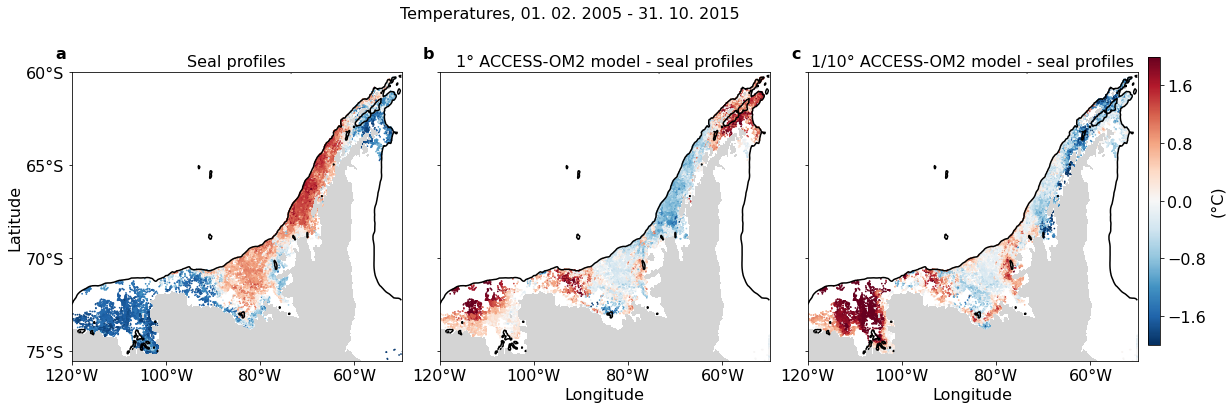

In [16]:
%%time
fontsize = 16
depth_slice = 200

# Take mean of cycle2 and cycle3:
iaf_temp = (cycle3_temp+cycle2_temp)/2
iaf_temp_1deg = (cycle5_temp+cycle6_temp)/2

fig = plt.figure(figsize=(16,10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3) 
       
# first panel with seal OBS data
# -------------------------------------------------------------------------------------------------- #
for f in [0,1,2]:
    if f == 0:
        panel = gs[0,0]; lon = lon_obs; lat = lat_obs; data = meop_temp; scale = 1; title_str = 'Seal profiles'
    if f == 1:
        panel = gs[0,1]; lon = lon_model; lat = lat_model; data = (iaf_temp_1deg-meop_temp); scale = 1; title_str = '1° ACCESS-OM2 model - seal profiles'        
    if f == 2:
        panel = gs[0,2]; lon = lon_model; lat = lat_model; data = (iaf_temp-meop_temp); scale = 1; title_str = '1/10° ACCESS-OM2 model - seal profiles'         
#     if f == 4:
#         panel = gs[1,1]; lon = lon_model; lat = lat_model; data = iaf_temp_1deg-meop_temp; scale = 1; title_str = 'ACCESS-OM2-1 \n difference to seal profiles'        
#     if f == 5:
#         panel = gs[1,2]; lon = lon_model; lat = lat_model; data = iaf_temp-meop_temp; scale = 1; title_str = 'ACCESS-OM2-01 \n difference to seal profiles'     
        
        
    ax1 = plt.subplot(panel)    

    ascii_nrs = [0,1,2,0,3,4]
    ax1.text(-.05, 1.05, string.ascii_lowercase[ascii_nrs[f]], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

    sc = plt.scatter(lon,lat,c=data,s=.5,cmap='RdBu_r',vmin=-2,vmax=2)
    cbar.set_label('(°C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

    plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k', linewidth=1.25)
    plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='#d4d4d4') # light grey land
    plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0],linewidth='4',colors='black') # light grey land

    

    plt.xlim(-120,-50); plt.ylim(-75.5,-60)
    plt.tick_params(labelsize=fontsize)
    # replace lables with °W/°S labels
    labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['120°W', '100°W', '80°W', '60°W']) # replace labels in °N with across-shelf distance
    plt.locator_params(axis='y', nbins=4) # only 4 y-axis ticks
    labels = [item.get_text() for item in ax1.get_yticklabels()]; ax1.set_yticklabels(['', '75°S', '70°S', '65°S', '60°S'])

    if f in [4,5]:
        # adding the region rectangles for AS and BS
        AS = [-127,-101,-77,-70]; BS = [-101,-80,-77,-70]; PR = [-80,-63, -74, -63]
        # # drawing the AS and BS rectangles
        for r in range(4): # loop through the four sides of the rectangle
            if r == 0: lons = [AS[0],AS[1]]; lats = [AS[2], AS[2]] # bottom
            if r == 1: lons = [AS[0],AS[1]]; lats = [AS[3], AS[3]] # top
            if r == 2: lons = [AS[0],AS[0]]; lats = [AS[2], AS[3]] # left
            if r == 3: lons = [AS[1],AS[1]]; lats = [AS[2], AS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        for r in range(3): # loop through the four sides of the rectangle
            if r == 0: lons = [BS[0],BS[1]]; lats = [BS[2], BS[2]] # bottom
            if r == 1: lons = [BS[0],BS[1]]; lats = [BS[3], BS[3]] # top
            if r == 2: lons = [BS[1],BS[1]]; lats = [BS[2], BS[3]] # right
            txt = plt.plot([lons[0],lons[1]], [lats[0], lats[1]], color = 'black', linewidth=2)
        # adding text label
        ax1.text( -119, -75, 'AS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -75, 'BS',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 

    plt.title(title_str, fontsize=fontsize) # add title

    if f in [0]: plt.ylabel('Latitude',fontsize=fontsize); plt.xlabel(None)
    if f in [1,2,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None) 
    # if f in [1,2]:   ax1.set_xticklabels([]); ax1.set(xlabel=None) # remove superfluous labels
    plt.xlabel('Longitude', fontsize=fontsize)

    if f in [0]: 
        plt.xlabel(None)            
        # add colour bar 
        # cax = fig.add_axes([.07, .4, .25, .02]) # for horizontal colour bar
        #                 ([x0, y0, width, height])
        cax = fig.add_axes([1, .51,   .01,     .4]) # for vertical colour bar

        cb = plt.colorbar(sc, cax = cax, shrink=1, orientation='vertical'); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        # cb.add_lines(p11) # add contours to colour bar
        
    if f in [4,5]:
        # Calculate the bias that goes into the AS and BS regions
        diff = data # difference between OBS and model
        
        # mask out all Amundsen Sea profiles, fill rest with nan and  replace all non-nan values with the 1 index
        AS_profiles = (lon_obs.where((lon_obs > -120) & (lon_obs < -101))).fillna(np.nan); AS_profiles = AS_profiles.where(np.logical_or(AS_profiles.isnull(), xr==0), 1)
        bias_AS = str(np.round((diff*AS_profiles).mean().values,2)) + '°C'

        BS_profiles = (lon_model.where((lon_model > -101) & (lon_model < -80))).fillna(np.nan); BS_profiles = BS_profiles.where(np.logical_or(BS_profiles.isnull(), xr==0), 1)
        bias_BS = str(np.round((diff*BS_profiles).mean().values,2)) + '°C'

        # add the model bias in the AS and BS into the boxes
        ax1.text( -119, -69.5, bias_AS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        ax1.text( -100, -69.5, bias_BS,va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
        
plt.suptitle('Temperatures, 01. 02. 2005 - 31. 10. 2015 \n', fontsize=fontsize)

# --- saving as 300 dpi .PNG image in specified folder ---------------------------- #
plt.savefig(save + 'Seal_OBS_ACCESS-OM2-1_ACCESS-OM2-01_iaf_comparison_differences', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                 #
            format=None, transparent=False, bbox_inches='tight',                    #
            pad_inches=0.1, metadata=None)                                          #
# --- end of script --------------------------------------------------------------- #
# Wall time: 5.16 s

Caption notes:
- landmask and 1000 dbar taken from OBS in all three panels
- model data = mean of IAF cycle2 + cycle3
- Amundsen Sea only going to 120°W
- I think this is the temperature distribution in 1000 m depth, not the mean between the surface and 1000 m depth

### SOSE: load in Amundsen/Bellingshausen Sea climatological temperature

In [17]:
%%time
# 2160
sel_lon   = [1260, 1801] # [1260:1801] = 150°W - 60°W
sel_lat   = [0, 322]           # [0, 121] = 79°S - 58°S, [0, 322] = 78°S - 60°S
depth = [0,36]             # [0, 36] = 2.1 - 1000 m, [0, 30] = 2.1 - 500 m

temp_SOSE = xr.open_dataset('/g/data/ua8/SOSE/BSOSE6_iter133/'+'bsose_i133_2013to2018_monthly_Theta.nc').THETA.mean('time')[depth[0]:depth[1],sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
temp_SOSE = temp_SOSE.where(temp_SOSE !=0) # replace all zeroes by nan
# Wall time: 

CPU times: user 31.8 s, sys: 38.7 s, total: 1min 10s
Wall time: 1min 25s


Text(0.5, 1.0, 'Transect at 75°W')

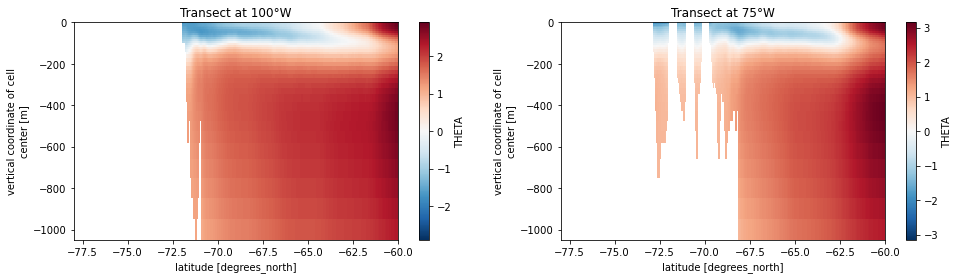

In [18]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); temp_SOSE[:,:,300].plot(); plt.title('Transect at 100°W')
plt.subplot(1,2,2); temp_SOSE[:,:,450].plot(); plt.title('Transect at 75°W')

SOSE goes from 2012-12-01 52 months forward to 2017-04-01, that means I need the same time period for the ACCESS-OM2 data from the IAF runs

### ACCESS-OM2-025: load in Amundsen/Bellingshausen Sea climatological temperature

### Now loading in ACCESS-OM2-01 data as well

In [19]:
import cosima_cookbook as cc
session = cc.database.create_session()
# cc.querying.get_experiments(session, all=True)

In [20]:
%%time
# base_rmh = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output'
# ---------------------------------------------------------------------------------- #
time      = [   2,   55]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSOE  #
depth     = [   0,   47]  # [  0,    47] = 0.5 m - 1017 m                            #
sel_lat   = [  51,  489]  # [  51,  489] = 78.95°S - 60.09°S                         #
sel_lonWA = [1299, 2200]  # 150°W - 60°W                                             #
# ---------------------------------------------------------------------------------- #
temp_ACCESS_01 = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='temp', 
                                    session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time='2012-12-01 00:00:00', 
                                    end_time='2017-04-01 00:00:00', 
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time[0]:time[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]].mean('time')
# Wall time: 4.47 s

CPU times: user 557 ms, sys: 227 ms, total: 784 ms
Wall time: 1.17 s


In [21]:
# ---------------------------------------------------------------------------------- #
time      = [  11,   64]  # [  11,   64] = 2012-12-14 to 2017-04-14 just like SOSE   #
depth     = [   0,   29]  # [   0,   29] = 1.1 m - 1029 m                            #
sel_lat   = [   0,   43]  # [   0,   50] = 77.8°S - 60.6°S                           #
sel_lonWA = [ 129,  220]  # [ 129,  220] = 150.5°W - 60.5°W                          #
# ---------------------------------------------------------------------------------- #
temp_ACCESS_1 = cc.querying.getvar(expt='1deg_jra55_iaf_omip2_cycle6', variable='temp', 
                                    session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time='2012-12-01 00:00:00', 
                                    end_time='2017-04-01 00:00:00', 
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time[0]:time[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lonWA[0]:sel_lonWA[1]].mean('time')

In [22]:
%%time
# load data into memory
SOSE_ABS = temp_SOSE[:,:,300].load();                   SOSE_WAP = temp_SOSE[:,:,450].load()
ACCESS01_ABS = (temp_ACCESS_01[:,:,500]-273.15).load(); ACCESS01_WAP = (temp_ACCESS_01[:,:,750]-273.15).load()
ACCESS1_ABS = (temp_ACCESS_1[:,:,50]-273.15).load();    ACCESS1_WAP = (temp_ACCESS_1[:,:,75]-273.15).load()
# Wall time: 4.37 s

CPU times: user 1.93 s, sys: 430 ms, total: 2.36 s
Wall time: 10.5 s


### Plotting routine again

CPU times: user 1.82 s, sys: 235 ms, total: 2.05 s
Wall time: 1.82 s


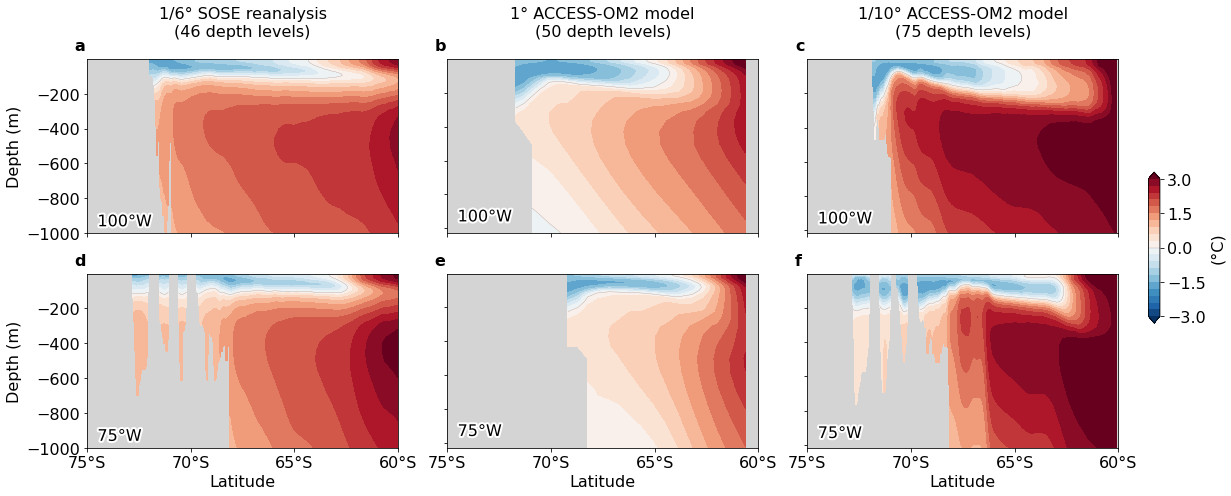

In [51]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  
 
def fancy_plot2(ax, titel):
    ax1.set_facecolor([.83, .83, .83]) # grey background for the shelf

    plt.title(titel, fontsize=16)
    plt.ylabel('Depth (m)', fontsize=16)
    plt.xlabel('Latitude', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    # # add colour bar 
    # cb = plt.colorbar(p1, shrink=1, orientation='vertical') # add colour bar  
    # cb.set_label(label='(°C)', size=16)
    # cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    # cb.locator = tick_locator; cb.update_ticks()  
    # cb.add_lines(p11) # add contours to colour bar

    # # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['', '220', '165', '110', '55', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
    plt.locator_params(axis='y', nbins=6) # only six y-axis ticks

    
fig = plt.figure(figsize=(16, 7),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3, width_ratios = [1,1,1], height_ratios = [1,1]) 
ticks_depth_lat = np.linspace(-3,3,21)

for f in range(6): # loop through each subplot
                                                                                               # isotherm positions during the event
    if f == 0:  panel = gs[0,0]; data = SOSE_ABS;     titel = '1/6° SOSE reanalysis\n(46 depth levels)\n'
    if f == 1:  panel = gs[0,1]; data = ACCESS1_ABS;  titel = '1° ACCESS-OM2 model\n(50 depth levels)\n'
    if f == 2:  panel = gs[0,2]; data = ACCESS01_ABS; titel = '1/10° ACCESS-OM2 model\n(75 depth levels)\n'
    if f == 3:  panel = gs[1,0]; data = SOSE_WAP;     titel = ''
    if f == 4:  panel = gs[1,1]; data = ACCESS1_WAP;  titel = ''
    if f == 5:  panel = gs[1,2]; data = ACCESS01_WAP; titel = ''

    # saving the data for plotting as a netcdf file
    data_set_type = ['SOSE reanalysis', '1° ACCESS-OM2 model', '1/10° ACCESS-OM2 model', '', '1° ACCESS-OM2 model', '1/10° ACCESS-OM2 model']
    # adding global attributes
    data.attrs = {'Units': '[°C]', 
                   'Project': 'Subsurface warming of the West Antarctic continental shelf linked to El Niño-Southern Oscillation',
                   'Author': 'Maurice F. Huguenin', 
                   'Created': '2023-06-15',
                   'Model': data_set_type[f],
                   'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                   'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
    panel_label = ['a', 'b', 'c', 'd', 'e', 'f']
    data_set = ['SOSE', 'ACCESS-OM2-1', 'ACCESS-OM2-01', 'SOSE', 'ACCESS-OM2-1', 'ACCESS-OM2-01']
    data.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS1' + panel_label[f] + '_' + data_set[f]+ '.nc')

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    ax1 = plt.subplot(panel)
        
    # -------- #
    p1  = data.plot.contourf(ax=ax1, levels = ticks_depth_lat, cmp='RdBu_r',extend='both', add_colorbar=False, yincrease=False)
    p11 = data.plot.contour(levels = [0], linewidths=.25, cmap='grey')
    # if f in [1,3]: plt.ylim([max(data.st_ocean),min(data.st_ocean)]) 
    # p22 = iso.plot.contour(levels=[-2, -1.75, -1.5, -1, -.5, 0, .25, .5], linewidths=1, cmap='k', yincrease=False)
    # ax1.clabel(p22,  # Typically best results when labelling line contours.
    #            colors=['black'], fontsize=16,
    #            manual=False,  # Automatic placement vs manual placement.
    #            inline=True),  # Cut the line where the label will be placed.
    #            # fmt=' {:.05f} '.format)  # Labes as integers, with some extra space.
    # -------- #
    
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['', '-110', '-55', '0', '55', '110', '165', '220', '270']
    # ax1.set_xticklabels(labels)  

    plt.locator_params(axis='x', nbins=5)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels =       ['75°S', '70°S', '65°S', '60°S', ]
    ax1.set_xticklabels(labels) 
    
    plt.xlim([-75,-60]) # limits for x-axis
    fancy_plot2(ax1, titel)

    ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    

    if f in [1,2,4,5]: plt.gca().invert_yaxis() # inverse y-axis for ACCESS-OM2 models
    # hide superfluous tick labels and ticks
    if f in [0,1,2]: ax1.set_xticklabels([]); ax1.set(xlabel=None)           
    if f in [1,2,4,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None)     
       
    if f in [0]: ax1.text(-74.5,-960, '100°W', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
    if f in [3]: ax1.text(-74.5,-960, '75°W', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
    if f in [1,2]: ax1.text(-74.5,960, '100°W', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
    if f in [4,5]: ax1.text(-74.5,960, '75°W', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
        
    if f == 3:
        # add colour bar
        cax = fig.add_axes([1, .35, .01, .3]) # position: [x0, y0, width, height]
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar
         
        
# --- saving as 300 dpi .PNG image in specified folder ---------------------------------- #
plt.savefig(save + 'SOSE_comparison_ACCESS-OM2-01_ACCESS-OM2-1', dpi=300, facecolor='w',  #
            edgecolor='w', orientation='landscape', papertype=None,                       #
            format=None, transparent=False, bbox_inches='tight',                          #
            pad_inches=0.1, metadata=None)                                                #
# --- end of script --------------------------------------------------------------------- # 
# Wall time: 1.42 s

### next, I need to plot the difference between the two but need to remap onto the other grid for it to work

In [24]:
%%time
import scipy
for f in range(4):
    if f == 0: data = ACCESS01_ABS
    if f == 1: data = ACCESS1_ABS
    if f == 2: data = ACCESS01_WAP
    if f == 3: data = ACCESS1_WAP
    
    # create interpolation function      (           old x-axis,            old y-axis,     old data)
    function = scipy.interpolate.interp2d(data.yt_ocean, data.st_ocean, data.fillna(9999)) 
    interpolated_data = function(SOSE_ABS.YC, SOSE_ABS.Z*-1) # use function to interpolate onto SOSE grid
    interpolated_data[interpolated_data>4]=np.nan # to get the nan back, replace all data that is above 4°C with nan
        
    if f == 0: ACCESS01_ABS_interp = interpolated_data
    if f == 1: ACCESS1_ABS_interp  = interpolated_data
    if f == 2: ACCESS01_WAP_interp = interpolated_data
    if f == 3: ACCESS1_WAP_interp  = interpolated_data
# Wall time: 14.2 ms

CPU times: user 28.9 ms, sys: 845 µs, total: 29.8 ms
Wall time: 94.3 ms


### Plotting routine with only the differences

CPU times: user 1.88 s, sys: 243 ms, total: 2.13 s
Wall time: 1.84 s


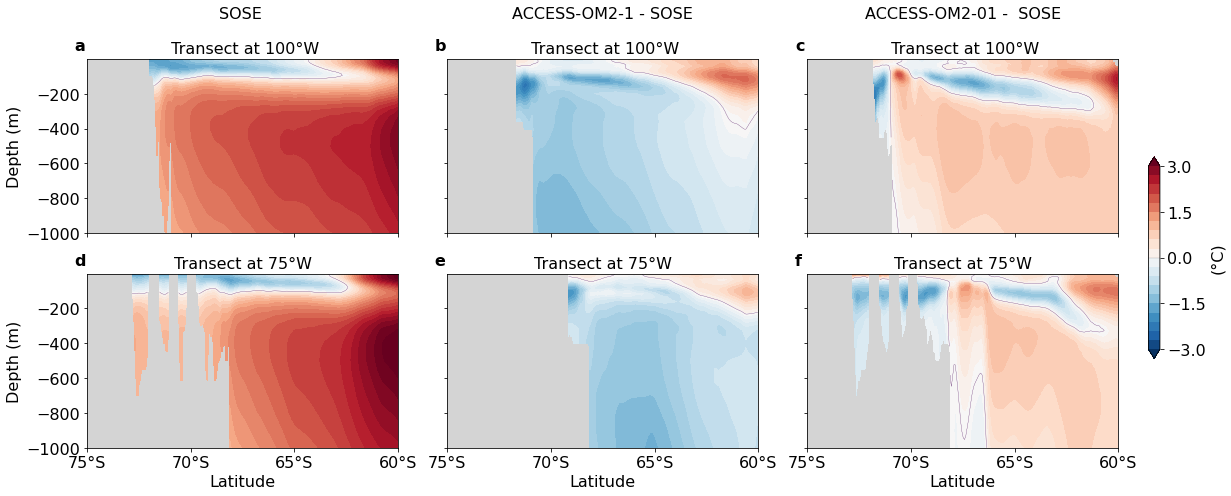

In [25]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  
 
def fancy_plot2(ax, titel):
    ax1.set_facecolor([.83, .83, .83]) # grey background for the shelf

    plt.title(titel, fontsize=16)
    plt.ylabel('Depth (m)', fontsize=16)
    plt.xlabel('Latitude', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    # # add colour bar 
    # cb = plt.colorbar(p1, shrink=1, orientation='vertical') # add colour bar  
    # cb.set_label(label='(°C)', size=16)
    # cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    # cb.locator = tick_locator; cb.update_ticks()  
    # cb.add_lines(p11) # add contours to colour bar

    # # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['', '220', '165', '110', '55', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
    plt.locator_params(axis='y', nbins=6) # only six y-axis ticks

    
fig = plt.figure(figsize=(16, 7),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,3, width_ratios = [1,1,1], height_ratios = [1,1]) 
ticks_depth_lat = np.linspace(-3,3,42)

for f in range(6): # loop through each subplot
                                                                                               # isotherm positions during the event
    if f == 0:  panel = gs[0,0]; data = SOSE_ABS;                       titel = 'SOSE \n\n Transect at 100°W'
    if f == 1:  panel = gs[0,1]; data = (ACCESS1_ABS_interp-SOSE_ABS);  titel = 'ACCESS-OM2-1 - SOSE\n\n Transect at 100°W'
    if f == 2:  panel = gs[0,2]; data = (ACCESS01_ABS_interp-SOSE_ABS); titel = 'ACCESS-OM2-01 -  SOSE\n\n Transect at 100°W'
    if f == 3:  panel = gs[1,0]; data = SOSE_WAP;                       titel = 'Transect at 75°W'
    if f == 4:  panel = gs[1,1]; data = (ACCESS1_WAP_interp-SOSE_WAP);  titel = 'Transect at 75°W'
    if f == 5:  panel = gs[1,2]; data = (ACCESS01_WAP_interp-SOSE_WAP); titel = 'Transect at 75°W'

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    ax1 = plt.subplot(panel)
        
    # -------- #
    plt.contourf(SOSE_ABS.YC, SOSE_ABS.Z, data, levels=ticks_depth_lat, cmap='RdBu_r', extend='both')
    plt.contour( SOSE_ABS.YC, SOSE_ABS.Z, data, levels = [0], linewidths=.25, c='grey')
       
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['', '-110', '-55', '0', '55', '110', '165', '220', '270']
    # ax1.set_xticklabels(labels)  

    plt.locator_params(axis='x', nbins=5)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels =       ['75°S', '70°S', '65°S', '60°S', ]
    ax1.set_xticklabels(labels) 
    
    plt.xlim([-75,-60]) # limits for x-axis
    fancy_plot2(ax1, titel)
    ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # if f in [1,2,4,5]: plt.gca().invert_yaxis() # inverse y-axis for ACCESS-OM2 models
    # hide superfluous tick labels and ticks
    if f in [0,1,2]: ax1.set_xticklabels([]); ax1.set(xlabel=None)           
    if f in [1,2,4,5]: ax1.set_yticklabels([]); ax1.set(ylabel=None)     
       
    if f == 3:
        # add colour bar
        cax = fig.add_axes([1, .28, .01, .4]) # position: [x0, y0, width, height]
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical'); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar
         
        
# --- saving as 300 dpi .PNG image in specified folder ---------------------------------------------- #
plt.savefig(save + 'SOSE_comparison_ACCESS-OM2-01_ACCESS-OM2-1_differences', dpi=300, facecolor='w',  #
            edgecolor='w', orientation='landscape', papertype=None,                                   #
            format=None, transparent=False, bbox_inches='tight',                                      #
            pad_inches=0.1, metadata=None)                                                            #
# --- end of script --------------------------------------------------------------------------------- # Wall time: 6.75 s

In [26]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #